In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
import geopandas as gpd
from geopy.distance import great_circle
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, BoundaryNorm, LinearSegmentedColormap
import matplotlib.dates as mdates
import numpy as np
import os
import pandas as pd
from pyproj import Transformer
import xarray as xr
import string

import warnings
warnings.filterwarnings('ignore')

In [2]:
### Load data
dsn_hv = xr.open_zarr('/pl/active/WRFLES_GAD/wfp_3dpbl/real/3dpbl/nwf/2020_08/final.zarr')
dsv_hv = xr.open_zarr('/pl/active/WRFLES_GAD/wfp_3dpbl/real/3dpbl/vw-only/2020_08/final.zarr')
dsf_hv = xr.open_zarr('/pl/active/WRFLES_GAD/wfp_3dpbl/real/3dpbl/lease/2020_08/final.zarr')

dsn_m = xr.open_zarr('/pl/active/WRFLES_GAD/wfp_3dpbl/real/mynn-wrf4.3/nwf/2020_08/final.zarr')
dsv_m = xr.open_zarr('/pl/active/WRFLES_GAD/wfp_3dpbl/real/mynn-wrf4.3/vw-only/2020_08/final.zarr')
dsf_m = xr.open_zarr('/pl/active/WRFLES_GAD/wfp_3dpbl/real/mynn-wrf4.3/lease/2020_08/final.zarr')

In [3]:
### Grab basic data about files
## Times
times_n_hv = dsn_hv['time'].values
times_v_hv = dsv_hv['time'].values
times_f_hv = dsf_hv['time'].values

times_n_m = dsn_m['time'].values
times_v_m = dsv_m['time'].values
times_f_m = dsf_m['time'].values

## Coords
lons = dsn_hv['lon'].values
lats = dsn_hv['lat'].values
mean_lon = lons.mean()
mean_lat = lats.mean()

## Heights
heights = dsn_hv['height'].values

In [4]:
### Replace Time iterator data with timestamps
dsn_m = dsn_m.assign_coords({'Time':dsn_m['time'].data})
dsv_m = dsv_m.assign_coords({'Time':dsv_m['time'].data})
dsf_m = dsf_m.assign_coords({'Time':dsf_m['time'].data})
dsn_hv = dsn_hv.assign_coords({'Time':dsn_hv['time'].data})
dsv_hv = dsv_hv.assign_coords({'Time':dsv_hv['time'].data})
dsf_hv = dsf_hv.assign_coords({'Time':dsf_hv['time'].data})

In [5]:
### Calculate common time index for Aug 2020
## Prepare start and end index to trim timestamps to only Aug 2020
start_time = np.datetime64('2020-08-01')
end_time = np.datetime64('2020-09-01')

trimtime_n_hv_start = np.where(times_n_hv==start_time)[0][0]
trimtime_n_hv_end = np.where(times_n_hv==end_time)[0][0]
trimtime_v_hv_start = np.where(times_v_hv==start_time)[0][0]
trimtime_v_hv_end = np.where(times_v_hv==end_time)[0][0]
trimtime_f_hv_start = np.where(times_f_hv==start_time)[0][0]
trimtime_f_hv_end = np.where(times_f_hv==end_time)[0][0]

trimtime_n_m_start = np.where(times_n_m==start_time)[0][0]
trimtime_n_m_end = np.where(times_n_m==end_time)[0][0]
trimtime_v_m_start = np.where(times_v_m==start_time)[0][0]
trimtime_v_m_end = np.where(times_v_m==end_time)[0][0]
trimtime_f_m_start = np.where(times_f_m==start_time)[0][0]
trimtime_f_m_end = np.where(times_f_m==end_time)[0][0]

times = times_n_hv[trimtime_n_hv_start:trimtime_n_hv_end]

In [6]:
### Read turbine data
turbine_file_vw = 'windturbines_vw.txt'
turbine_df_vw = pd.read_csv(turbine_file_vw, delim_whitespace=True, usecols=[0,1], names=['Lat', 'Long'])
n_turb_vw = len(turbine_df_vw)

turbine_file_full = 'windturbines_full.txt'
turbine_df_full = pd.read_csv(turbine_file_full, delim_whitespace=True, usecols=[0,1], names=['Lat', 'Long'])
n_turb_full = len(turbine_df_full)

In [7]:
### Read idealized turbine data
turbine_file = '/projects/olry2348/WFIP2-WRF-3DPBL/runs/idealized/neutral/mynn-ztke/windturbines-ij.txt'
turbine_df = pd.read_csv(turbine_file, delim_whitespace=True, usecols=[0,1], names=['i', 'j'])

turbine_properties = '/projects/olry2348/WFIP2-WRF-3DPBL/runs/idealized/neutral/mynn-ztke/wind-turbine-1.tbl'
f = open(turbine_properties, "r")
lines = f.readlines()
hubheight = np.float(lines[1].split()[0])
rotor_diameter = np.float(lines[1].split()[1])
rotor_top = hubheight + rotor_diameter/2
rotor_bot = hubheight - rotor_diameter/2

print("Hub height", hubheight)
print("Rotor diameter", rotor_diameter)

Hub height 138.0
Rotor diameter 215.0


In [8]:
### Pull key parameters out of turbine files
turb_lat_min_vw = turbine_df_vw['Lat'].min()
turb_lat_max_vw = turbine_df_vw['Lat'].max()
turb_long_min_vw = turbine_df_vw['Long'].min()
turb_long_max_vw = turbine_df_vw['Long'].max()

turb_lat_min_full = turbine_df_full['Lat'].min()
turb_lat_max_full = turbine_df_full['Lat'].max()
turb_long_min_full = turbine_df_full['Long'].min()
turb_long_max_full = turbine_df_full['Long'].max()

MAP_BOUNDS_turb_vw = [turb_long_min_vw-1, turb_long_max_vw+1, turb_lat_min_vw-1, turb_lat_max_vw+0.5]
MAP_BOUNDS_turb_vw2 = [-71, -69.75, 40.5, 41.5]
MAP_BOUNDS_turb_vw_zoom = [turb_long_min_vw-0.1, turb_long_max_vw+0.1, turb_lat_min_vw-0.1, turb_lat_max_vw+0.1]
MAP_BOUNDS_turb_full = [turb_long_min_full-0.5, turb_long_max_full+0.5, turb_lat_min_full-0.3, turb_lat_max_full+0.5]

In [9]:
### Identify ij of grid cells within VW
## Open copied list of turbine data from rsl.out.0000
with open('wind-turbine-locs.txt') as f:
    lines = f.readlines()
    
## Grab turbine number, west_east number, and south_north number
turb_list_ij_vw = []
for i in range(len(lines)):
    if i%2==0: continue   # Skip every other line
    turb_num = int(lines[i][52:55].strip())   # We include this for some testing, but ultimately drop
    west_east_num = int(lines[i][120:123])-1  # Subtract 1 because Python indexing
    south_north_num = int(lines[i][134:137])-1
    turb_list_ij_vw.append([turb_num, west_east_num, south_north_num])
    
## Format into dataframe
turb_df_ij_vw = pd.DataFrame(np.array(turb_list_ij_vw), columns=['Num', 'west_east_num', 'south_north_num'])

## Count the number of turbines in each cell
turb_cell_count = turb_df_ij_vw.groupby(["west_east_num", "south_north_num"]).size().reset_index(name="Count").copy()

## Drop duplicates
turb_df_ij_vw = turb_df_ij_vw.drop(labels='Num', axis=1)
turb_df_ij_vw = turb_df_ij_vw.drop_duplicates()

## Add info on turbines per cell
turb_df_ij_vw['TurbPerCell'] = 0
for i in range(len(turb_df_ij_vw)):
    unique_i = turb_df_ij_vw['west_east_num'].iloc[i]
    unique_j = turb_df_ij_vw['south_north_num'].iloc[i]
    unique_ind = turb_df_ij_vw[(turb_df_ij_vw['west_east_num']==unique_i) \
                               & (turb_df_ij_vw['south_north_num']==unique_j)].index[0]

    turb_per_cell = turb_cell_count[(turb_cell_count['west_east_num']==unique_i) \
                   & (turb_cell_count['south_north_num']==unique_j)]['Count'].values[0]
    
    turb_df_ij_vw.loc[unique_ind, 'TurbPerCell'] = turb_per_cell
    
## Cleanup
turb_df_ij_vw = turb_df_ij_vw.reset_index()
turb_df_ij_vw = turb_df_ij_vw.drop(columns=['index'])

In [10]:
### Prepare map elements
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m')
states_50m = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', '50m')

land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m')
states_10m = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', '10m')

In [11]:
### Process shapefiles for lease areas
## Load shapefiles
# df_lease = gpd.read_file('/home/orybchuk/shapefiles/BOEM_Lease_Areas_3_29_2021.shp')
df_lease = gpd.read_file('/projects/olry2348/shapefiles/BOEM_Lease_Areas_3_29_2021.shp')
crs = ccrs.PlateCarree()

## Merge (aka dissolve) geometries by lease area
df_lease_group = df_lease.dissolve(by='LeaseNo_Co')
df_lease_group = df_lease_group[~df_lease_group.index.str.contains('Virginia')]
df_lease_group = df_lease_group[~df_lease_group.index.str.contains('Avangrid Renewables')]
df_lease_group = df_lease_group[~df_lease_group.index.str.contains('Oregon')] 
df_lease_group = df_lease_group[~df_lease_group.index.str.contains('Narragansett')]

In [12]:
### Calculate centroids of all lease areas
## Calculate centroid in an equal area projection
lease_centroid_lat = df_lease_group.to_crs('+proj=cea').centroid.to_crs(df_lease_group.crs).y
lease_centroid_lon = df_lease_group.to_crs('+proj=cea').centroid.to_crs(df_lease_group.crs).x

df_lease_group['CentroidLat'] = lease_centroid_lat
df_lease_group['CentroidLon'] = lease_centroid_lon

## Calculate grid cell closest to centroid
lease_centroid_i = np.zeros_like(lease_centroid_lon)
lease_centroid_j = np.zeros_like(lease_centroid_lat)

for i in range(len(lease_centroid_lat)):
    centroid_dists = np.sqrt((lats - lease_centroid_lat[i])**2 \
                        + (lons - lease_centroid_lon[i])**2)

    this_j, this_i = np.unravel_index(np.argmin(centroid_dists, axis=None), centroid_dists.shape)
    
    lease_centroid_i[i], lease_centroid_j[i] = this_i, this_j
    
df_lease_group['CentroidI'] = lease_centroid_i.astype(int)
df_lease_group['CentroidJ'] = lease_centroid_j.astype(int)

# Internal waking

### Colorbars

In [13]:
### Create custom colorbars
def calc_viridis_colorbar(cm_min, cm_max, cm_interval):
    '''
    Calculate tick bounds, a discrete colormap, and a norm for use with pcolormesh plots
    '''
    custom_bounds = np.arange(cm_min, cm_max+cm_interval, cm_interval) 

    all_colors = plt.cm.viridis(np.linspace(0, 1, int((cm_max-cm_min)/cm_interval)))

    custom_cmap = LinearSegmentedColormap.from_list('custom_map',
        all_colors)
    custom_cmap.set_over('magenta')
    custom_cmap.set_under('magenta')
    custom_cmap.set_bad('magenta')

    custom_norm = BoundaryNorm(custom_bounds, custom_cmap.N)
    
    return custom_bounds, custom_cmap, custom_norm
    
def calc_diverging_colorbar(cm_min, cm_max, cm_center, cm_interval):
    '''
    Calculate tick bounds, a discrete colormap, and a norm for use with pcolormesh plots
    '''

    custom_bounds = np.arange(cm_min, cm_max+cm_interval, cm_interval) 

    colors_pos = plt.cm.Reds(np.linspace(0, 
                                         (cm_max-cm_center)/(cm_max-cm_min),
                                          int((cm_max-cm_center)/cm_interval)))
    colors_neg = plt.cm.Blues_r(np.linspace(0, 
    #                                      (cm_center-cm_min)/(cm_max-cm_min), # Use truncated part of Blues_r
                                            1,  # Use full range of Blues_r
                                          int((cm_center-cm_min)/cm_interval)))
    all_colors = np.vstack((colors_neg, colors_pos))

    custom_cmap = LinearSegmentedColormap.from_list('custom_map',
        all_colors)
    custom_cmap.set_over('magenta')
    custom_cmap.set_under('magenta')
    custom_cmap.set_bad('magenta')

    custom_norm = BoundaryNorm(custom_bounds, custom_cmap.N)
    
    return custom_bounds, custom_cmap, custom_norm

# Mean wakes by stability

In [14]:
### Calculate stable/neutral/unstable periods at Vineyard Wind
## Identify VW centroid
vw_i = df_lease_group.loc['OCS-A 0501 - Vineyard Wind LLC', 'CentroidI']
vw_j = df_lease_group.loc['OCS-A 0501 - Vineyard Wind LLC', 'CentroidJ']

## Grab heat fluxes (for binning)
hfx_m = dsn_m['HFX'].isel(south_north=vw_j, west_east=vw_i, Time=slice(trimtime_n_m_start, trimtime_n_m_end))
hfx_hv = dsn_hv['HFX'].isel(south_north=vw_j, west_east=vw_i, Time=slice(trimtime_n_hv_start, trimtime_n_hv_end))

# Set threshold
stable_thresh = -5   # W/m2
unstable_thresh = 5  # W/m2

# Grab timestamps
times_s_m = hfx_m[hfx_m < stable_thresh]['Time'].values
times_n_m = hfx_m[(hfx_m > stable_thresh) & (hfx_m < unstable_thresh)]['Time'].values
times_u_m = hfx_m[hfx_m > unstable_thresh]['Time'].values

times_s_hv = hfx_hv[hfx_hv < stable_thresh]['Time'].values
times_n_hv = hfx_hv[(hfx_hv > stable_thresh) & (hfx_hv < unstable_thresh)]['Time'].values
times_u_hv = hfx_hv[hfx_hv > unstable_thresh]['Time'].values

## Calculate winds by stability
k_hub = 6

# MYNN
dsn_m['MeanWspdHubStable'] = dsn_m['WSPD'].isel(bottom_top=k_hub).sel(Time=times_s_m).mean('Time').compute()
dsn_m['MeanWspdHubNeutral'] = dsn_m['WSPD'].isel(bottom_top=k_hub).sel(Time=times_n_m).mean('Time').compute()
dsn_m['MeanWspdHubUnstable'] = dsn_m['WSPD'].isel(bottom_top=k_hub).sel(Time=times_u_m).mean('Time').compute()

dsv_m['MeanWspdHubStable'] = dsv_m['WSPD'].isel(bottom_top=k_hub).sel(Time=times_s_m).mean('Time').compute()
dsv_m['MeanWspdHubNeutral'] = dsv_m['WSPD'].isel(bottom_top=k_hub).sel(Time=times_n_m).mean('Time').compute()
dsv_m['MeanWspdHubUnstable'] = dsv_m['WSPD'].isel(bottom_top=k_hub).sel(Time=times_u_m).mean('Time').compute()

dsf_m['MeanWspdHubStable'] = dsf_m['WSPD'].isel(bottom_top=k_hub).sel(Time=times_s_m).mean('Time').compute()
dsf_m['MeanWspdHubNeutral'] = dsf_m['WSPD'].isel(bottom_top=k_hub).sel(Time=times_n_m).mean('Time').compute()
dsf_m['MeanWspdHubUnstable'] = dsf_m['WSPD'].isel(bottom_top=k_hub).sel(Time=times_u_m).mean('Time').compute()

# 3DPBL
dsn_hv['MeanWspdHubStable'] = dsn_hv['WSPD'].isel(bottom_top=k_hub).sel(Time=times_s_hv).mean('Time').compute()
dsn_hv['MeanWspdHubNeutral'] = dsn_hv['WSPD'].isel(bottom_top=k_hub).sel(Time=times_n_hv).mean('Time').compute()
dsn_hv['MeanWspdHubUnstable'] = dsn_hv['WSPD'].isel(bottom_top=k_hub).sel(Time=times_u_hv).mean('Time').compute()

dsv_hv['MeanWspdHubStable'] = dsv_hv['WSPD'].isel(bottom_top=k_hub).sel(Time=times_s_hv).mean('Time').compute()
dsv_hv['MeanWspdHubNeutral'] = dsv_hv['WSPD'].isel(bottom_top=k_hub).sel(Time=times_n_hv).mean('Time').compute()
dsv_hv['MeanWspdHubUnstable'] = dsv_hv['WSPD'].isel(bottom_top=k_hub).sel(Time=times_u_hv).mean('Time').compute()

dsf_hv['MeanWspdHubStable'] = dsf_hv['WSPD'].isel(bottom_top=k_hub).sel(Time=times_s_hv).mean('Time').compute()
dsf_hv['MeanWspdHubNeutral'] = dsf_hv['WSPD'].isel(bottom_top=k_hub).sel(Time=times_n_hv).mean('Time').compute()
dsf_hv['MeanWspdHubUnstable'] = dsf_hv['WSPD'].isel(bottom_top=k_hub).sel(Time=times_u_hv).mean('Time').compute()

In [15]:
### Calcualte internal wake magnitude
## Prep internal wake magintude variable
# VW_ONLY
int_wake_sum_sv_m = 0
int_wake_sum_nv_m = 0
int_wake_sum_uv_m = 0
int_wake_sum_sv_hv = 0
int_wake_sum_nv_hv = 0
int_wake_sum_uv_hv = 0

# All lease areas
int_wake_sum_sf_m = 0
int_wake_sum_nf_m = 0
int_wake_sum_uf_m = 0
int_wake_sum_sf_hv = 0
int_wake_sum_nf_hv = 0
int_wake_sum_uf_hv = 0

## Iterate over grid cells
for i in range(len(turb_df_ij_vw)):
    iloc = turb_df_ij_vw['west_east_num'].iloc[i]
    jloc = turb_df_ij_vw['south_north_num'].iloc[i]
    
    int_wake_sum_sv_m += (dsv_m['MeanWspdHubStable']-dsn_m['MeanWspdHubStable']).isel(
                            west_east=iloc, south_north=jloc)
    int_wake_sum_nv_m += (dsv_m['MeanWspdHubNeutral']-dsn_m['MeanWspdHubNeutral']).isel(
                            west_east=iloc, south_north=jloc)
    int_wake_sum_uv_m += (dsv_m['MeanWspdHubUnstable']-dsn_m['MeanWspdHubUnstable']).isel(
                            west_east=iloc, south_north=jloc)
    
    int_wake_sum_sf_m += (dsf_m['MeanWspdHubStable']-dsn_m['MeanWspdHubStable']).isel(
                            west_east=iloc, south_north=jloc)
    int_wake_sum_nf_m += (dsf_m['MeanWspdHubNeutral']-dsn_m['MeanWspdHubNeutral']).isel(
                            west_east=iloc, south_north=jloc)
    int_wake_sum_uf_m += (dsf_m['MeanWspdHubUnstable']-dsn_m['MeanWspdHubUnstable']).isel(
                            west_east=iloc, south_north=jloc)
    
    int_wake_sum_sv_hv += (dsv_hv['MeanWspdHubStable']-dsn_hv['MeanWspdHubStable']).isel(
                            west_east=iloc, south_north=jloc)
    int_wake_sum_nv_hv += (dsv_hv['MeanWspdHubNeutral']-dsn_hv['MeanWspdHubNeutral']).isel(
                            west_east=iloc, south_north=jloc)
    int_wake_sum_uv_hv += (dsv_hv['MeanWspdHubUnstable']-dsn_hv['MeanWspdHubUnstable']).isel(
                            west_east=iloc, south_north=jloc)
    
    int_wake_sum_sf_hv += (dsf_hv['MeanWspdHubStable']-dsn_hv['MeanWspdHubStable']).isel(
                            west_east=iloc, south_north=jloc)
    int_wake_sum_nf_hv += (dsf_hv['MeanWspdHubNeutral']-dsn_hv['MeanWspdHubNeutral']).isel(
                            west_east=iloc, south_north=jloc)
    int_wake_sum_uf_hv += (dsf_hv['MeanWspdHubUnstable']-dsn_hv['MeanWspdHubUnstable']).isel(
                            west_east=iloc, south_north=jloc)
    
## Calculate average internal wake
int_wake_mean_sv_m = int_wake_sum_sv_m.values / len(turb_df_ij_vw)
int_wake_mean_nv_m = int_wake_sum_nv_m.values / len(turb_df_ij_vw)
int_wake_mean_uv_m = int_wake_sum_uv_m.values / len(turb_df_ij_vw)

int_wake_mean_sf_m = int_wake_sum_sf_m.values / len(turb_df_ij_vw)
int_wake_mean_nf_m = int_wake_sum_nf_m.values / len(turb_df_ij_vw)
int_wake_mean_uf_m = int_wake_sum_uf_m.values / len(turb_df_ij_vw)

int_wake_mean_sv_hv = int_wake_sum_sv_hv.values / len(turb_df_ij_vw)
int_wake_mean_nv_hv = int_wake_sum_nv_hv.values / len(turb_df_ij_vw)
int_wake_mean_uv_hv = int_wake_sum_uv_hv.values / len(turb_df_ij_vw)

int_wake_mean_sf_hv = int_wake_sum_sf_hv.values / len(turb_df_ij_vw)
int_wake_mean_nf_hv = int_wake_sum_nf_hv.values / len(turb_df_ij_vw)
int_wake_mean_uf_hv = int_wake_sum_uf_hv.values / len(turb_df_ij_vw)

## Store internal wake calculation
dsv_m.attrs['IntWakeStable'] = int_wake_mean_sv_m
dsv_m.attrs['IntWakeNeutral'] = int_wake_mean_nv_m
dsv_m.attrs['IntWakeUnstable'] = int_wake_mean_uv_m

dsf_m.attrs['IntWakeStable'] = int_wake_mean_sf_m
dsf_m.attrs['IntWakeNeutral'] = int_wake_mean_nf_m
dsf_m.attrs['IntWakeUnstable'] = int_wake_mean_uf_m

dsv_hv.attrs['IntWakeStable'] = int_wake_mean_sv_hv
dsv_hv.attrs['IntWakeNeutral'] = int_wake_mean_nv_hv
dsv_hv.attrs['IntWakeUnstable'] = int_wake_mean_uv_hv

dsf_hv.attrs['IntWakeStable'] = int_wake_mean_sf_hv
dsf_hv.attrs['IntWakeNeutral'] = int_wake_mean_nf_hv
dsf_hv.attrs['IntWakeUnstable'] = int_wake_mean_uf_hv

In [16]:
### Calculate average NWF wind speed across the area
## Prep the variable
nwf_wind_sum_sv_m = 0
nwf_wind_sum_nv_m = 0
nwf_wind_sum_uv_m = 0
nwf_wind_sum_sv_hv = 0
nwf_wind_sum_nv_hv = 0
nwf_wind_sum_uv_hv = 0

## Iterate over grid cells
for i in range(len(turb_df_ij_vw)):
    iloc = turb_df_ij_vw['west_east_num'].iloc[i]
    jloc = turb_df_ij_vw['south_north_num'].iloc[i]
    
    nwf_wind_sum_sv_m += dsn_m['MeanWspdHubStable'].isel(west_east=iloc, south_north=jloc)
    nwf_wind_sum_nv_m += dsn_m['MeanWspdHubNeutral'].isel(west_east=iloc, south_north=jloc)
    nwf_wind_sum_uv_m += dsn_m['MeanWspdHubUnstable'].isel(west_east=iloc, south_north=jloc)
    
    nwf_wind_sum_sv_hv += dsn_hv['MeanWspdHubStable'].isel(west_east=iloc, south_north=jloc)
    nwf_wind_sum_nv_hv += dsn_hv['MeanWspdHubNeutral'].isel(west_east=iloc, south_north=jloc)
    nwf_wind_sum_uv_hv += dsn_hv['MeanWspdHubUnstable'].isel(west_east=iloc, south_north=jloc)
    
## Calculate average wind speed
nwf_wind_sum_sv_m = nwf_wind_sum_sv_m.values / len(turb_df_ij_vw)
nwf_wind_sum_nv_m = nwf_wind_sum_nv_m.values / len(turb_df_ij_vw)
nwf_wind_sum_uv_m = nwf_wind_sum_uv_m.values / len(turb_df_ij_vw)

nwf_wind_sum_sv_hv = nwf_wind_sum_sv_hv.values / len(turb_df_ij_vw)
nwf_wind_sum_nv_hv = nwf_wind_sum_nv_hv.values / len(turb_df_ij_vw)
nwf_wind_sum_uv_hv = nwf_wind_sum_uv_hv.values / len(turb_df_ij_vw)

## Store internal wake calculation
dsn_m.attrs['AvgWindStable'] = nwf_wind_sum_sv_m
dsn_m.attrs['AvgWindNeutral'] = nwf_wind_sum_nv_m
dsn_m.attrs['AvgWindUnstable'] = nwf_wind_sum_uv_m

dsn_hv.attrs['AvgWindStable'] = nwf_wind_sum_sv_hv
dsn_hv.attrs['AvgWindNeutral'] = nwf_wind_sum_nv_hv
dsn_hv.attrs['AvgWindUnstable'] = nwf_wind_sum_uv_hv

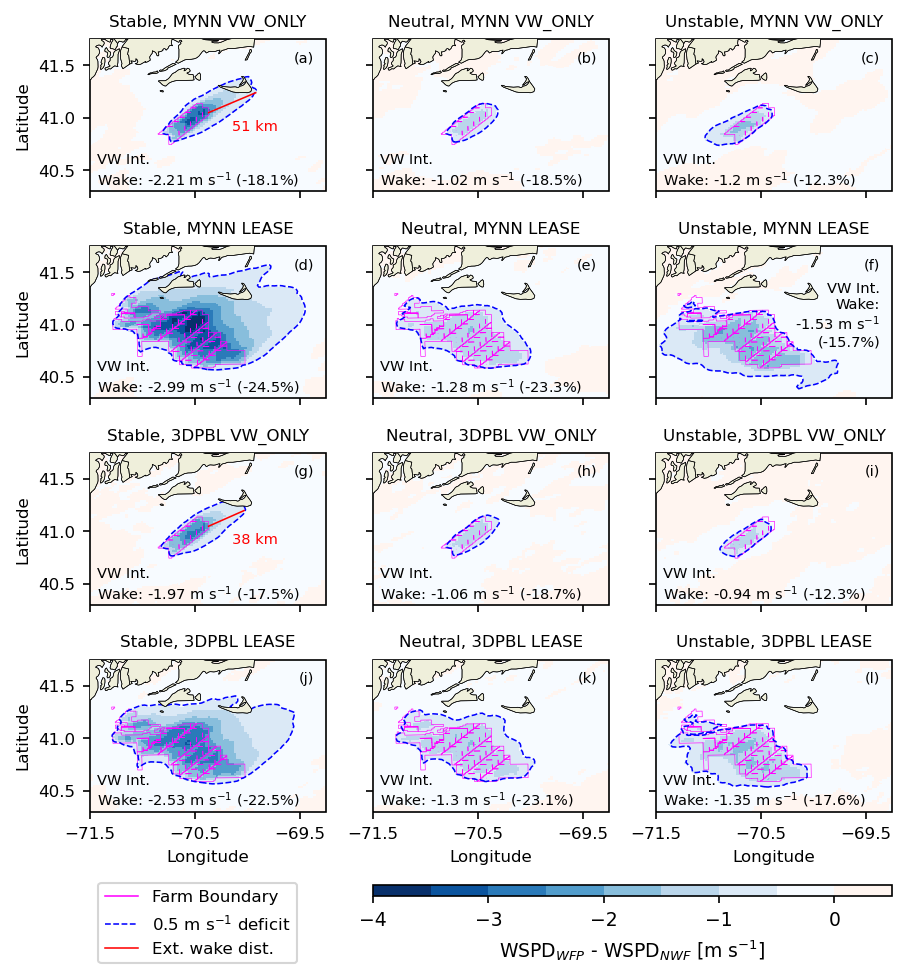

In [17]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(4, 3, figsize=(6.9, 7), subplot_kw=dict(projection=proj),
                          sharex=True, sharey=True, dpi=150)
ax[0,0].set_extent( [-71.1, -69.25, 40.3, 41.75])
# ax[0,0].set_extent(MAP_BOUNDS_turb_vw2)

## Decorate
xticks = [-71.5, -70.5, -69.5]
yticks = [40.5, 41, 41.5]
for axs in ax.flatten():
#     axs.add_geometries([df_lease_group['geometry'].loc['OCS-A 0501 - Vineyard Wind LLC']], 
#                          crs=crs, edgecolor='magenta', facecolor="none", linewidth=0.3)
    axs.xaxis.set_visible(True)
    axs.tick_params(labelsize=8)

    axs.add_feature(land_10m, facecolor=cfeature.COLORS['land'], zorder=100, edgecolor='k', linewidth=0.3) # Land
    axs.add_feature(states_10m, facecolor='None', zorder=101, edgecolor='k', linewidth=0.3)                # States
    axs.set_xticks(xticks)
    axs.set_yticks(yticks)


    
for axs in ax[-1,:].flatten():
    axs.set_xlabel("Longitude", fontsize=8)
for axs in ax[:,0].flatten():
    axs.set_ylabel("Latitude", fontsize=8)

ax[0,0].set_title("Stable, MYNN VW_ONLY", fontsize=8)
ax[0,1].set_title("Neutral, MYNN VW_ONLY", fontsize=8)
ax[0,2].set_title("Unstable, MYNN VW_ONLY", fontsize=8)
ax[1,0].set_title("Stable, MYNN LEASE", fontsize=8)
ax[1,1].set_title("Neutral, MYNN LEASE", fontsize=8)
ax[1,2].set_title("Unstable, MYNN LEASE", fontsize=8)
ax[2,0].set_title("Stable, 3DPBL VW_ONLY", fontsize=8)
ax[2,1].set_title("Neutral, 3DPBL VW_ONLY", fontsize=8)
ax[2,2].set_title("Unstable, 3DPBL VW_ONLY", fontsize=8)
ax[3,0].set_title("Stable, 3DPBL LEASE", fontsize=8)
ax[3,1].set_title("Neutral, 3DPBL LEASE", fontsize=8)
ax[3,2].set_title("Unstable, 3DPBL LEASE", fontsize=8)

## Set up colorbars
cm_center1 = 0
cm_min1 = -4
cm_max1 = 0.5
cm_interval1 = 0.5
ticks1, custom_cmap1, custom_norm1 = calc_diverging_colorbar(cm_min1, cm_max1, cm_center1, cm_interval1)

## Plot the data
for pbl, site, i in zip(['MYNN', 'MYNN', '3DPBL', '3DPBL'], ['VW', 'LEASE', 'VW', 'LEASE'], range(4)):

    if pbl == 'MYNN':
        dsn = dsn_m
        if site == 'VW':
            dst = dsv_m
        elif site == 'LEASE':
            dst = dsf_m
    elif pbl == '3DPBL':
        dsn = dsn_hv
        if site == 'VW':
            dst = dsv_hv
        elif site == 'LEASE':
            dst = dsf_hv
            
    ## Plot
    im1 = ax[i,0].pcolormesh(lons,
                 lats,
                 dst['MeanWspdHubStable']-dsn['MeanWspdHubStable'],
                 transform=ccrs.PlateCarree(),
                 cmap=custom_cmap1,
                 norm=custom_norm1)
    im1 = ax[i,1].pcolormesh(lons,
                 lats,
                 dst['MeanWspdHubNeutral']-dsn['MeanWspdHubNeutral'],
                 transform=ccrs.PlateCarree(),
                 cmap=custom_cmap1,
                 norm=custom_norm1)
    im1 = ax[i,2].pcolormesh(lons,
                 lats,
                 dst['MeanWspdHubUnstable']-dsn['MeanWspdHubUnstable'],
                 transform=ccrs.PlateCarree(),
                 cmap=custom_cmap1,
                 norm=custom_norm1)
    
    ## Mark 0.5 deficit contour
    ax[i,0].contour(lons,
                 lats,
                 dst['MeanWspdHubStable']-dsn['MeanWspdHubStable'],
                 [-0.5],
                 transform=ccrs.PlateCarree(),
                 colors='b',
                 linewidths=0.75)
    ax[i,1].contour(lons,
                 lats,
                 dst['MeanWspdHubNeutral']-dsn['MeanWspdHubNeutral'],
                 [-0.5],
                 transform=ccrs.PlateCarree(),
                 colors='b',
                 linewidths=0.75)
    ax[i,2].contour(lons,
                 lats,
                 dst['MeanWspdHubUnstable']-dsn['MeanWspdHubUnstable'],
                 [-0.5],
                 transform=ccrs.PlateCarree(),
                 colors='b',
                 linewidths=0.75)
    
#     ## Mark e-folding distance
#     ax[i,0].contour(lons,
#                  lats,
#                  dst['MeanWspdHubStable']-dsn['MeanWspdHubStable'],
#                  [dst.attrs['IntWakeStable']/np.e],
#                  transform=ccrs.PlateCarree(),
#                  colors='k',
#                  linewidths=0.75)
#     ax[i,1].contour(lons,
#                  lats,
#                  dst['MeanWspdHubNeutral']-dsn['MeanWspdHubNeutral'],
#                  [dst.attrs['IntWakeNeutral']/np.e],
#                  transform=ccrs.PlateCarree(),
#                  colors='k',
#                  linewidths=0.75)
#     ax[i,2].contour(lons,
#                  lats,
#                  dst['MeanWspdHubUnstable']-dsn['MeanWspdHubUnstable'],
#                  [dst.attrs['IntWakeUnstable']/np.e],
#                  transform=ccrs.PlateCarree(),
#                  colors='k',
#                  linewidths=0.75)

    ## Lease areas
    if site == 'VW':
        for axs in ax[i,:].flatten():
            axs.add_geometries([df_lease_group['geometry'].loc['OCS-A 0501 - Vineyard Wind LLC']], 
                         crs=crs, edgecolor='magenta', facecolor="none", linewidth=0.3)
    if site == 'LEASE':
        for axs in ax[i,:].flatten():
            for j in range(len(df_lease_group)):
                axs.add_geometries([df_lease_group['geometry'].iloc[j]], 
                             crs=crs, edgecolor='magenta', facecolor="none", linewidth=0.3)
    
    ## Internal wake labels
    avg_wake_pct_s = dst.attrs['IntWakeStable']/dsn.attrs['AvgWindStable']*100
    avg_wake_pct_n = dst.attrs['IntWakeNeutral']/dsn.attrs['AvgWindNeutral']*100
    avg_wake_pct_u = dst.attrs['IntWakeUnstable']/dsn.attrs['AvgWindUnstable']*100
    
    str_s = 'VW Int.\nWake: '+np.round(dst.attrs['IntWakeStable'],2).astype(str)+' m s$^{-1}$ (' \
                            +np.round(avg_wake_pct_s,1).astype(str)+'%)'
    str_n = 'VW Int.\nWake: '+np.round(dst.attrs['IntWakeNeutral'],2).astype(str)+' m s$^{-1}$ (' \
                            +np.round(avg_wake_pct_n,1).astype(str)+'%)'
    str_u = 'VW Int.\nWake: '+np.round(dst.attrs['IntWakeUnstable'],2).astype(str)+' m s$^{-1}$ (' \
                            +np.round(avg_wake_pct_u,1).astype(str)+'%)'

    for axs, label in zip(ax[i,:].flatten(), [str_s, str_n, str_u]):
        if ((label==str_u)&(pbl=='MYNN')&(site=='LEASE')):  # Special case because bad text location
            continue
        axs.text(0.03,
              0.04,
              label,
              fontsize=7,
              transform = axs.transAxes,
              horizontalalignment='left',
                color='black')
        
## Internal wake label (special case)
avg_wake_pct_u = dsf_m.attrs['IntWakeUnstable']/dsn_m.attrs['AvgWindUnstable']*100
str_u = 'VW Int.\nWake:\n'+np.round(dsf_m.attrs['IntWakeUnstable'],2).astype(str)+' m s$^{-1}$\n('\
                            +np.round(avg_wake_pct_u,1).astype(str)+'%)'
ax[1,2].text(0.95,
              0.34,
              str_u,
              fontsize=7,
              transform = ax[1,2].transAxes,
              horizontalalignment='right',
                color='black')


## Colorbar
cax1 = fig.add_axes([ax[-1,1].get_position().x0,
                     ax[-1,-1].get_position().y0-0.08,
                     ax[-1,2].get_position().x1-ax[-1,1].get_position().x0,
                     0.01])
cbar1 = fig.colorbar(im1, cax=cax1, ticks=ticks1[::2], orientation='horizontal')
cbar1.set_label('WSPD$_{WFP}$ - WSPD$_{NWF}$ [m s$^{-1}$]', fontsize=9)
cbar1.ax.tick_params(labelsize=9)   

## Subpanel labels
for axs, letter in zip(ax.flatten(), list(string.ascii_lowercase)):
    axs.text(0.95,
          0.85,
          f'({letter})',
          fontsize=7,
          transform = axs.transAxes,
          horizontalalignment='right',
            color='black')
    

## Legend
ax[-1,0].plot([-9999, -9999], [-10000, -9999], ls='-', lw=0.75, color='magenta', label='Farm Boundary') ## For legend
ax[-1,0].plot([-9999, -9999], [-10000, -9999], ls='--', lw=0.75, color='b', label='0.5 m s$^{-1}$ deficit') ## For legend
ax[-1,0].plot([-9999, -9999], [-10000, -9999], ls='-', lw=0.75, color='r', label='Ext. wake dist.') ## For legend

handles, labels = ax[-1,0].get_legend_handles_labels()
lgd = ax[-1,0].legend(handles, labels, bbox_to_anchor=(0.0, -1.05), loc='lower left', fontsize=8)

## Mark wake distance
ax[0,0].plot([-70.37, -69.92], 
             [41.05, 41.24],
             color='r',
             lw=0.75)
ax[0,0].text(0.6,
             0.4,
             f'{great_circle([-70.37, 41.05], [-69.92, 41.24]).km:.0f} km',
             transform = ax[0,0].transAxes,
             color='r',
             fontsize=7)

ax[2,0].plot([-70.37, -70.03], 
             [41.05, 41.20],
             color='r',
             lw=0.75)
ax[2,0].text(0.6,
             0.4,
             f'{great_circle([-70.37, 41.05], [-70.03, 41.20]).km:.0f} km',
             transform = ax[2,0].transAxes,
             color='r',
             fontsize=7)

# plt.savefig(f'../figs/vw_wspd_topdown.pdf', bbox_inches='tight')
# plt.savefig(f'../figs/vw_wspd_topdown.png', bbox_inches='tight')


plt.show()

In [18]:
### Calculate side views
## Manually select index closest to lat=41.0
lat_ind = 195
# print(dsn_m['lat'].isel(south_north=lat_ind).values.mean())

## Calculate
# MYNN
dsn_m['MeanWspdHubStableSide'] = dsn_m['WSPD'].isel(south_north=lat_ind).sel(Time=times_s_m).mean('Time').compute()
dsn_m['MeanWspdHubNeutralSide'] = dsn_m['WSPD'].isel(south_north=lat_ind).sel(Time=times_n_m).mean('Time').compute()
dsn_m['MeanWspdHubUnstableSide'] = dsn_m['WSPD'].isel(south_north=lat_ind).sel(Time=times_u_m).mean('Time').compute()

dsv_m['MeanWspdHubStableSide'] = dsv_m['WSPD'].isel(south_north=lat_ind).sel(Time=times_s_m).mean('Time').compute()
dsv_m['MeanWspdHubNeutralSide'] = dsv_m['WSPD'].isel(south_north=lat_ind).sel(Time=times_n_m).mean('Time').compute()
dsv_m['MeanWspdHubUnstableSide'] = dsv_m['WSPD'].isel(south_north=lat_ind).sel(Time=times_u_m).mean('Time').compute()

dsf_m['MeanWspdHubStableSide'] = dsf_m['WSPD'].isel(south_north=lat_ind).sel(Time=times_s_m).mean('Time').compute()
dsf_m['MeanWspdHubNeutralSide'] = dsf_m['WSPD'].isel(south_north=lat_ind).sel(Time=times_n_m).mean('Time').compute()
dsf_m['MeanWspdHubUnstableSide'] = dsf_m['WSPD'].isel(south_north=lat_ind).sel(Time=times_u_m).mean('Time').compute()

# 3DPBL
dsn_hv['MeanWspdHubStableSide'] = dsn_hv['WSPD'].isel(south_north=lat_ind).sel(Time=times_s_hv).mean('Time').compute()
dsn_hv['MeanWspdHubNeutralSide'] = dsn_hv['WSPD'].isel(south_north=lat_ind).sel(Time=times_n_hv).mean('Time').compute()
dsn_hv['MeanWspdHubUnstableSide'] = dsn_hv['WSPD'].isel(south_north=lat_ind).sel(Time=times_u_hv).mean('Time').compute()

dsv_hv['MeanWspdHubStableSide'] = dsv_hv['WSPD'].isel(south_north=lat_ind).sel(Time=times_s_hv).mean('Time').compute()
dsv_hv['MeanWspdHubNeutralSide'] = dsv_hv['WSPD'].isel(south_north=lat_ind).sel(Time=times_n_hv).mean('Time').compute()
dsv_hv['MeanWspdHubUnstableSide'] = dsv_hv['WSPD'].isel(south_north=lat_ind).sel(Time=times_u_hv).mean('Time').compute()

dsf_hv['MeanWspdHubStableSide'] = dsf_hv['WSPD'].isel(south_north=lat_ind).sel(Time=times_s_hv).mean('Time').compute()
dsf_hv['MeanWspdHubNeutralSide'] = dsf_hv['WSPD'].isel(south_north=lat_ind).sel(Time=times_n_hv).mean('Time').compute()
dsf_hv['MeanWspdHubUnstableSide'] = dsf_hv['WSPD'].isel(south_north=lat_ind).sel(Time=times_u_hv).mean('Time').compute()

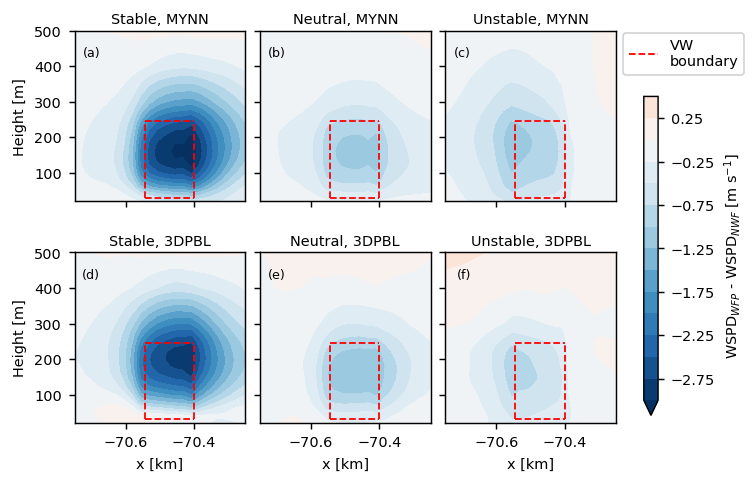

In [19]:
fig, ax = plt.subplots(2, 3, figsize=(5.5, 4), sharex=True, sharey=True, dpi=130)

plt_lon = dsn_m['lon'].isel(south_north=lat_ind).values

# turb_df_ij_vw[turb_df_ij_vw['south_north_num']==lat_ind]
# xbounds_vw = dsn_m['lon'].isel(west_east=[234,240]).values.mean(axis=0)

for axs in ax.reshape(-1):
    axs.set_box_aspect(1)
    axs.tick_params(labelsize=8)
    
    axs.plot([-70.545105, -70.545105], [rotor_bot, rotor_top], ls='--', color='r', lw=1, label='VW\nboundary')
    axs.plot([-70.400246, -70.400246], [rotor_bot, rotor_top], ls='--', color='r', lw=1)
    axs.plot([-70.545105, -70.400246], [rotor_bot, rotor_bot], ls='--', color='r', lw=1)
    axs.plot([-70.545105, -70.400246], [rotor_top, rotor_top], ls='--', color='r', lw=1)
    
ax[0,0].set_xlim(-70.75,-70.25)
ax[0,0].set_ylim(20,500)

for i in range(3):
    ax[-1,i].set_xlabel("x [km]", fontsize=8)
for i in range(2):
    ax[i,0].set_ylabel("Height [m]", fontsize=8)

## Plot parameters
# ticks_right = np.arange(-1.625, 0.875, 0.125)
ticks_right = np.arange(-3, 0.75, 0.25)

## Select simulation case
for pbl, site, i in zip(['MYNN', '3DPBL'], ['VW', 'VW'], range(2)):

    if pbl == 'MYNN':
        dsn = dsn_m
        if site == 'VW':
            dst = dsv_m
        elif site == 'LEASE':
            dst = dsf_m
    elif pbl == '3DPBL':
        dsn = dsn_hv
        if site == 'VW':
            dst = dsv_hv
        elif site == 'LEASE':
            dst = dsf_hv

    im1 = ax[i,0].contourf(plt_lon,
                            heights,
                            dst['MeanWspdHubStableSide']-dsn['MeanWspdHubStableSide'],
                            ticks_right,
                            cmap=plt.cm.RdBu_r, norm=TwoSlopeNorm(0, vmin=-1*np.abs(ticks_right).max(), vmax=np.abs(ticks_right).max()),
                            extend='min')
    im1 = ax[i,1].contourf(plt_lon,
                            heights,
                            dst['MeanWspdHubNeutralSide']-dsn['MeanWspdHubNeutralSide'],
                            ticks_right,
                            cmap=plt.cm.RdBu_r, norm=TwoSlopeNorm(0, vmin=-1*np.abs(ticks_right).max(), vmax=np.abs(ticks_right).max()),
                            extend='min')
    im1 = ax[i,2].contourf(plt_lon,
                            heights,
                            dst['MeanWspdHubUnstableSide']-dsn['MeanWspdHubUnstableSide'],
                            ticks_right,
                            cmap=plt.cm.RdBu_r, norm=TwoSlopeNorm(0, vmin=-1*np.abs(ticks_right).max(), vmax=np.abs(ticks_right).max()),
                            extend='min')
    
    # Title
    ax[i,0].set_title(f"Stable, {pbl}", fontsize=8, pad=4)
    ax[i,1].set_title(f"Neutral, {pbl}", fontsize=8, pad=4)
    ax[i,2].set_title(f"Unstable, {pbl}", fontsize=8, pad=4)

    
## Colorbar
cax1 = fig.add_axes([ax[0,-1].get_position().x1+0.03,
                     ax[1,-1].get_position().y0,
                     0.02,
                     ax[1,-1].get_position().y1-ax[1,-1].get_position().y0+0.3])
cbar1 = fig.colorbar(im1, cax=cax1, ticks=ticks_right[1::2])
cbar1.set_label('WSPD$_{WFP}$ - WSPD$_{NWF}$ [m s$^{-1}$]', fontsize=8)
cbar1.ax.tick_params(labelsize=8)     

## Legend
handles, labels = ax[0,0].get_legend_handles_labels()
lgd = ax[0,-1].legend(handles, labels, bbox_to_anchor=(1.0, 0.7), loc='lower left', fontsize=8)

## Subpanel labels
for axs, letter in zip(ax.flatten(), list(string.ascii_lowercase)):
    axs.text(0.15,
          0.85,
          f'({letter})',
          fontsize=7,
          transform = axs.transAxes,
          horizontalalignment='right',
            color='black')
    
plt.subplots_adjust(wspace=0.01, hspace=0.3)

# plt.savefig(f'../figs/vw_wspd_side.pdf', bbox_inches='tight')
# plt.savefig(f'../figs/vw_wspd_side.png', bbox_inches='tight')

plt.show()

### TKE

In [20]:
### Calculate TKE maps
# MYNN
dsn_m['MeanTKEHubStable'] = dsn_m['TKE'].isel(bottom_top=k_hub).sel(Time=times_s_m).mean('Time').compute()
dsn_m['MeanTKEHubNeutral'] = dsn_m['TKE'].isel(bottom_top=k_hub).sel(Time=times_n_m).mean('Time').compute()
dsn_m['MeanTKEHubUnstable'] = dsn_m['TKE'].isel(bottom_top=k_hub).sel(Time=times_u_m).mean('Time').compute()

dsv_m['MeanTKEHubStable'] = dsv_m['TKE'].isel(bottom_top=k_hub).sel(Time=times_s_m).mean('Time').compute()
dsv_m['MeanTKEHubNeutral'] = dsv_m['TKE'].isel(bottom_top=k_hub).sel(Time=times_n_m).mean('Time').compute()
dsv_m['MeanTKEHubUnstable'] = dsv_m['TKE'].isel(bottom_top=k_hub).sel(Time=times_u_m).mean('Time').compute()

dsf_m['MeanTKEHubStable'] = dsf_m['TKE'].isel(bottom_top=k_hub).sel(Time=times_s_m).mean('Time').compute()
dsf_m['MeanTKEHubNeutral'] = dsf_m['TKE'].isel(bottom_top=k_hub).sel(Time=times_n_m).mean('Time').compute()
dsf_m['MeanTKEHubUnstable'] = dsf_m['TKE'].isel(bottom_top=k_hub).sel(Time=times_u_m).mean('Time').compute()

# 3DPBL
dsn_hv['MeanTKEHubStable'] = dsn_hv['TKE'].isel(bottom_top=k_hub).sel(Time=times_s_hv).mean('Time').compute()
dsn_hv['MeanTKEHubNeutral'] = dsn_hv['TKE'].isel(bottom_top=k_hub).sel(Time=times_n_hv).mean('Time').compute()
dsn_hv['MeanTKEHubUnstable'] = dsn_hv['TKE'].isel(bottom_top=k_hub).sel(Time=times_u_hv).mean('Time').compute()

dsv_hv['MeanTKEHubStable'] = dsv_hv['TKE'].isel(bottom_top=k_hub).sel(Time=times_s_hv).mean('Time').compute()
dsv_hv['MeanTKEHubNeutral'] = dsv_hv['TKE'].isel(bottom_top=k_hub).sel(Time=times_n_hv).mean('Time').compute()
dsv_hv['MeanTKEHubUnstable'] = dsv_hv['TKE'].isel(bottom_top=k_hub).sel(Time=times_u_hv).mean('Time').compute()

dsf_hv['MeanTKEHubStable'] = dsf_hv['TKE'].isel(bottom_top=k_hub).sel(Time=times_s_hv).mean('Time').compute()
dsf_hv['MeanTKEHubNeutral'] = dsf_hv['TKE'].isel(bottom_top=k_hub).sel(Time=times_n_hv).mean('Time').compute()
dsf_hv['MeanTKEHubUnstable'] = dsf_hv['TKE'].isel(bottom_top=k_hub).sel(Time=times_u_hv).mean('Time').compute()

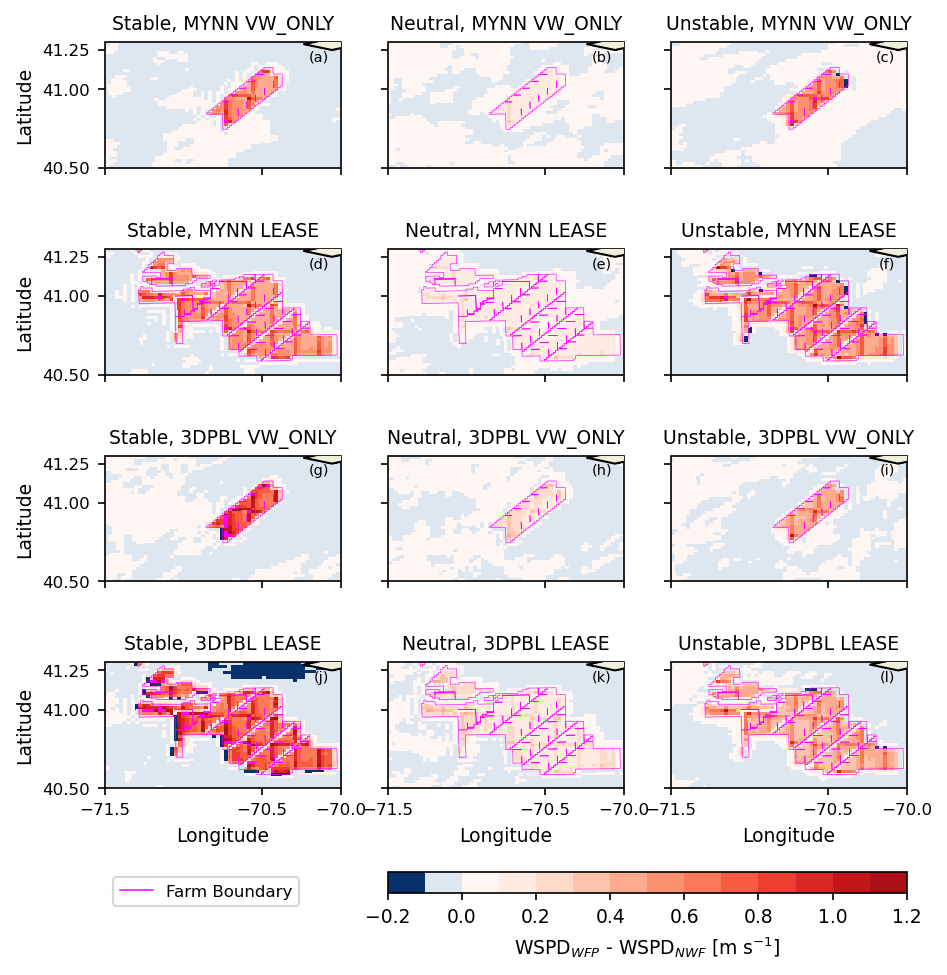

In [21]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(4, 3, figsize=(6.9, 7), subplot_kw=dict(projection=proj),
                          sharex=True, sharey=True, dpi=150)
ax[0,0].set_extent( [-71.1, -70, 40.5, 41.3])
# ax[0,0].set_extent(MAP_BOUNDS_turb_vw2)

## Decorate
xticks = [-71.5, -70.5, -70]
yticks = [40.5, 41, 41.25]
for axs in ax.flatten():
#     axs.add_geometries([df_lease_group['geometry'].loc['OCS-A 0501 - Vineyard Wind LLC']], 
#                          crs=crs, edgecolor='magenta', facecolor="none", linewidth=0.3)
    axs.xaxis.set_visible(True)
    axs.tick_params(labelsize=8)

    axs.add_feature(land_50m, facecolor=cfeature.COLORS['land'], zorder=100, edgecolor='k', linewidth=0.1) # Land
    axs.add_feature(states_50m, facecolor='None', zorder=101, edgecolor='k')                # States
    axs.set_xticks(xticks)
    axs.set_yticks(yticks)


    
for axs in ax[-1,:].flatten():
    axs.set_xlabel("Longitude", fontsize=9)
for axs in ax[:,0].flatten():
    axs.set_ylabel("Latitude", fontsize=9)

ax[0,0].set_title("Stable, MYNN VW_ONLY", fontsize=9)
ax[0,1].set_title("Neutral, MYNN VW_ONLY", fontsize=9)
ax[0,2].set_title("Unstable, MYNN VW_ONLY", fontsize=9)
ax[1,0].set_title("Stable, MYNN LEASE", fontsize=9)
ax[1,1].set_title("Neutral, MYNN LEASE", fontsize=9)
ax[1,2].set_title("Unstable, MYNN LEASE", fontsize=9)
ax[2,0].set_title("Stable, 3DPBL VW_ONLY", fontsize=9)
ax[2,1].set_title("Neutral, 3DPBL VW_ONLY", fontsize=9)
ax[2,2].set_title("Unstable, 3DPBL VW_ONLY", fontsize=9)
ax[3,0].set_title("Stable, 3DPBL LEASE", fontsize=9)
ax[3,1].set_title("Neutral, 3DPBL LEASE", fontsize=9)
ax[3,2].set_title("Unstable, 3DPBL LEASE", fontsize=9)

## Set up colorbars
cm_center1 = 0
cm_min1 = -0.2
cm_max1 = 1.2
cm_interval1 = 0.1
ticks1, custom_cmap1, custom_norm1 = calc_diverging_colorbar(cm_min1, cm_max1, cm_center1, cm_interval1)

## Plot the data
for pbl, site, i in zip(['MYNN', 'MYNN', '3DPBL', '3DPBL'], ['VW', 'LEASE', 'VW', 'LEASE'], range(4)):

    if pbl == 'MYNN':
        dsn = dsn_m
        if site == 'VW':
            dst = dsv_m
        elif site == 'LEASE':
            dst = dsf_m
    elif pbl == '3DPBL':
        dsn = dsn_hv
        if site == 'VW':
            dst = dsv_hv
        elif site == 'LEASE':
            dst = dsf_hv
            
    ## Plot
    im1 = ax[i,0].pcolormesh(lons,
                 lats,
                 dst['MeanTKEHubStable']-dsn['MeanTKEHubStable'],
                 transform=ccrs.PlateCarree(),
                 cmap=custom_cmap1,
                 norm=custom_norm1)
    im1 = ax[i,1].pcolormesh(lons,
                 lats,
                 dst['MeanTKEHubNeutral']-dsn['MeanTKEHubNeutral'],
                 transform=ccrs.PlateCarree(),
                 cmap=custom_cmap1,
                 norm=custom_norm1)
    im1 = ax[i,2].pcolormesh(lons,
                 lats,
                 dst['MeanTKEHubUnstable']-dsn['MeanTKEHubUnstable'],
                 transform=ccrs.PlateCarree(),
                 cmap=custom_cmap1,
                 norm=custom_norm1)

    ## Lease areas
    if site == 'VW':
        for axs in ax[i,:].flatten():
            axs.add_geometries([df_lease_group['geometry'].loc['OCS-A 0501 - Vineyard Wind LLC']], 
                         crs=crs, edgecolor='magenta', facecolor="none", linewidth=0.3)
    if site == 'LEASE':
        for axs in ax[i,:].flatten():
            for j in range(len(df_lease_group)):
                axs.add_geometries([df_lease_group['geometry'].iloc[j]], 
                             crs=crs, edgecolor='magenta', facecolor="none", linewidth=0.3)


## Colorbar
cax1 = fig.add_axes([ax[-1,1].get_position().x0,
                     ax[-1,-1].get_position().y0-0.10,
                     ax[-1,2].get_position().x1-ax[-1,1].get_position().x0,
                     0.02])
cbar1 = fig.colorbar(im1, cax=cax1, ticks=ticks1[::2], orientation='horizontal')
cbar1.set_label('WSPD$_{WFP}$ - WSPD$_{NWF}$ [m s$^{-1}$]', fontsize=9)
cbar1.ax.tick_params(labelsize=9)   

## Subpanel labels
for axs, letter in zip(ax.flatten(), list(string.ascii_lowercase)):
    axs.text(0.95,
          0.85,
          f'({letter})',
          fontsize=7,
          transform = axs.transAxes,
          horizontalalignment='right',
            color='black')
    

## Legend
ax[-1,0].plot([-9999, -9999], [-10000, -9999], ls='-', lw=0.75, color='magenta', label='Farm Boundary') ## For legend
# ax[1,0].plot([-9999, -9999], [-10000, -9999], ls='--', lw=0.75, color='k', label='$e$-folding dist.') ## For legend
# ax[-1,0].plot([-9999, -9999], [-10000, -9999], ls='--', lw=0.75, color='b', label='0.5 m s$^{-1}$ deficit') ## For legend

handles, labels = ax[-1,0].get_legend_handles_labels()
lgd = ax[-1,0].legend(handles, labels, bbox_to_anchor=(0.0, -1.0), loc='lower left', fontsize=8)

# plt.savefig(f'../figs/vw_tke_topdown.pdf', bbox_inches='tight')
# plt.savefig(f'../figs/vw_tke_topdown.png', bbox_inches='tight')

plt.show()